In [ ]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Dataset

In [ ]:
# from poc_data import PocDataset

# poc_raw_dataset = PocDataset(num_cases=2**10)
# data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=128)
# batch, event, time_to_event, _latent_variable = next(iter(data_loader))

# print(batch.shape)
# print(event.shape)
# print(time_to_event.shape)
# print(_latent_variable.shape)

### Data Exploration

In [ ]:
#Take a look at the longitudional data

# plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
# plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
# plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
# plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
# plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

# print(event[:5])
# print(time_to_event[:5])
# print(_latent_variable[:5])

# 2. Hyperparameters

In [ ]:
DEVICE = 'cuda'

# 3. Defining The Model

# 4. Training the model

tensor([[ 0.0000, 19.4477,  0.4239],
        [ 0.0000, 20.2744,  0.7448],
        [ 0.0000, 21.1012,  0.5850],
        [ 0.0000, 21.9279,  0.0476],
        [ 0.0000, 22.7546, -0.5205],
        [ 0.0000, 23.5814, -0.7527],
        [ 0.0000, 24.4081, -0.4990],
        [ 0.0000, 25.2348,  0.0767],
        [ 0.0000, 26.0616,  0.6029],
        [ 0.0000, 26.8883,  0.7400]], device='cuda:0')
event=1, time_to_event=15, latent_variable=0.752799


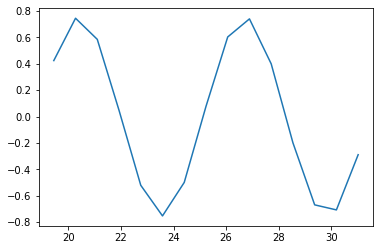

In [5]:
from poc_data import PocDataset

test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)
test_batch, test_event, test_time_to_event, test_latent_variable = next(iter(test_data_loader))
test_batch = test_batch.to(DEVICE)

plt.plot(np.array(test_batch.cpu()[0][:int(test_time_to_event[0]),1]), test_batch.cpu()[0][:int(test_time_to_event[0]),2])
print(test_batch[0,:10])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

In [6]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, RegressionNetwork, CauseSpecificSubnetwork
from losses import loss_1

#poc_raw_dataset = PocDataset(num_cases=2**5)
data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)

NUM_EPOCHS = 350

LEARNING_RATE_ENCODER = 0.001
LEARNING_RATE_DECODER = 0.001
LEARNING_RATE_REGRESS = 0.001
LEARNING_RATE_CAUSESS = 0.0005

LOSS_1_AMPLIFIER = 1
LOSS_3_AMPLIFIER = 1
LOSS_4_AMPLIFIER = 0

input_size = 3
output_size = input_size
MAX_LENGTH = 20
NUM_CAUSES = 2
hidden_size_encoder = 128
hidden_size_regress = 128
fc_size_encoder = 256

# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, output_size, MAX_LENGTH).to(DEVICE)
#regress = RegressionNetwork(hidden_size_encoder, hidden_size_regress).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
#optimizer_regress = Adam(regress.parameters(), lr=LEARNING_RATE_REGRESS)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)
 
# initialize loss
mse_loss = MSELoss()
writer = SummaryWriter()

tensor([[ 0.0888,  0.0204, -0.0288],
        [ 0.0814,  0.0299, -0.0114],
        [ 0.0796,  0.0329, -0.0066],
        [ 0.0775,  0.0354, -0.0043],
        [ 0.0751,  0.0373, -0.0026],
        [ 0.0733,  0.0388, -0.0018],
        [ 0.0727,  0.0406, -0.0009],
        [ 0.0732,  0.0431,  0.0004],
        [ 0.0740,  0.0456,  0.0019],
        [ 0.0738,  0.0473,  0.0038]], device='cuda:0')
event=1, time_to_event=15, latent_variable=0.752799


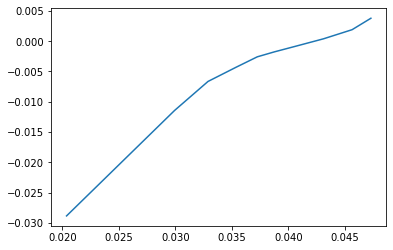

In [7]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
test_encoder_hidden = encoder.initHidden(device=DEVICE)

for ei in range(test_batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

test_last_measurement = test_batch[0][ei]
test_context_vector = decoder(test_last_measurement, test_encoder_hidden_vector)
#test_estimated_latent_variable = regress(test_context_vector)
test_first_hitting_time = causess(test_context_vector, test_last_measurement)

test_encoder_output_vector = test_encoder_output_vector.unsqueeze(0).detach()
plt.plot(np.array(test_encoder_output_vector.cpu()[0][0:10,1]), test_encoder_output_vector.cpu()[0][0:10,2])
print(test_encoder_output_vector[0,:10])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))
#print("real lv was %f, we estimated %f" % (test_latent_variable.item(), test_estimated_latent_variable.item()))

<BarContainer object of 40 artists>

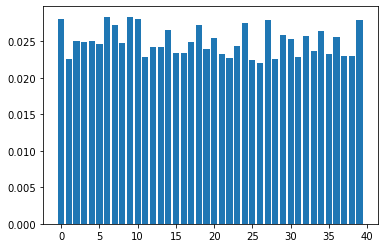

In [8]:

plt.bar([i for i in range(test_first_hitting_time.size(1))], test_first_hitting_time.squeeze().cpu().detach().numpy())
plt.ylim([0,1])

In [9]:
# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  optimizer_encoder.zero_grad()
  optimizer_decoder.zero_grad()
  #optimizer_regress.zero_grad()
  optimizer_causess.zero_grad()

  for i, data in enumerate(data_loader):

    batch, event, time_to_event, _latent_variable = data

    batch = batch.to(DEVICE)
    event = event.to(DEVICE)
    time_to_event = time_to_event.to(DEVICE)
    _latent_variable = _latent_variable.to(DEVICE)

    encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
    encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
    encoder_hidden = encoder.initHidden(device=DEVICE)

    for ei in range(batch.size(1)):
        encoder_input = batch[0][ei].view(1,1,-1)
        encoder_output, encoder_hidden = encoder(encoder_input, encoder_hidden)
        encoder_hidden_vector[ei] = encoder_hidden[0,0]
        encoder_output_vector[ei] = encoder_output

    last_measurement = batch[0][ei]
    context_vector = decoder(last_measurement, encoder_hidden_vector)
    #estimated_latent_variable = regress(context_vector)
    first_hitting_time = causess(context_vector, last_measurement)

    loss1 = loss_1(first_hitting_time, event, time_to_event, MAX_LENGTH)
    loss3 = mse_loss(encoder_output_vector[:-1], batch.detach().squeeze(0)[1:])
    loss4 = 0
    #loss4 = mse_loss(estimated_latent_variable, _latent_variable)

    epoch_loss += LOSS_1_AMPLIFIER*loss1 + LOSS_3_AMPLIFIER*loss3 + LOSS_4_AMPLIFIER*loss4

  writer.add_scalar('loss1', loss1.item(), epoch*len(data_loader) + i)
  writer.add_scalar('loss3', loss3.item(), epoch*len(data_loader) + i)
  writer.add_scalar('loss4', loss4, epoch*len(data_loader) + i)
  writer.add_scalar('loss_epoch', epoch_loss.item(), epoch)

  epoch_loss.backward()

  optimizer_encoder.step()
  #optimizer_decoder.step()
  #optimizer_causess.step()
  
print("av_epoch_train_loss=", epoch_loss.item()/len(data_loader))

100%|██████████| 250/250 [00:11<00:00, 22.23it/s]

av_epoch_train_loss= 43.32832336425781


tensor([[ 0.0000, 19.4477,  0.4239],
        [ 0.0000, 20.2744,  0.7448],
        [ 0.0000, 21.1012,  0.5850],
        [ 0.0000, 21.9279,  0.0476],
        [ 0.0000, 22.7546, -0.5205],
        [ 0.0000, 23.5814, -0.7527],
        [ 0.0000, 24.4081, -0.4990],
        [ 0.0000, 25.2348,  0.0767],
        [ 0.0000, 26.0616,  0.6029],
        [ 0.0000, 26.8883,  0.7400]], device='cuda:0')
event=1, time_to_event=15, latent_variable=0.752799


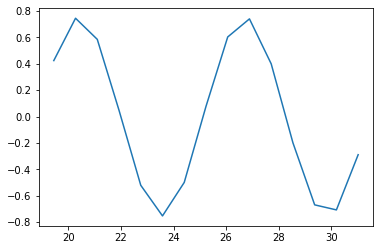

In [17]:
test_batch, test_event, test_time_to_event, test_latent_variable = next(iter(test_data_loader))
test_batch = test_batch.to(DEVICE)

plt.plot(np.array(test_batch.cpu()[0][:int(test_time_to_event[0]),1]), test_batch.cpu()[0][:int(test_time_to_event[0]),2])
print(test_batch[0,:10])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

tensor([[ 4.9846e-02,  2.1436e+01,  1.3421e-01],
        [ 1.0109e-01,  2.0387e+01, -4.4219e-02],
        [ 6.4876e-02,  2.3739e+01, -2.9179e-02],
        [ 4.5843e-02,  2.6562e+01, -4.2504e-03],
        [ 4.6298e-02,  2.7326e+01, -5.7884e-03],
        [ 5.3613e-02,  2.7111e+01, -2.0992e-02],
        [ 5.5611e-02,  2.7091e+01, -2.9438e-02],
        [ 4.8936e-02,  2.7778e+01, -2.1033e-02],
        [ 4.2221e-02,  2.8595e+01, -9.6494e-03],
        [ 4.1386e-02,  2.9031e+01, -6.0755e-03]], device='cuda:0')
event=1, time_to_event=15, latent_variable=0.752799


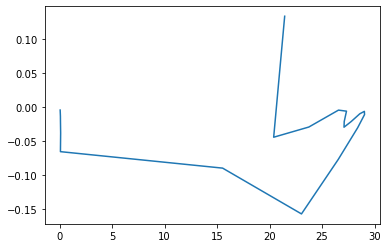

In [18]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
test_encoder_hidden = encoder.initHidden(device=DEVICE)

for ei in range(test_batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

test_last_measurement = test_batch[0][ei]
test_context_vector = decoder(test_last_measurement, test_encoder_hidden_vector)
#test_estimated_latent_variable = regress(test_context_vector)
test_first_hitting_time = causess(test_context_vector, test_last_measurement)

test_encoder_output_vector = test_encoder_output_vector.unsqueeze(0).detach()
plt.plot(np.array(test_encoder_output_vector.cpu()[0][0:23,1]), test_encoder_output_vector.cpu()[0][0:23,2])
print(test_encoder_output_vector[0,:10])
#print("real lv was %f, we estimated %f" % (test_latent_variable.item(), test_estimated_latent_variable.item()))
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

<BarContainer object of 40 artists>

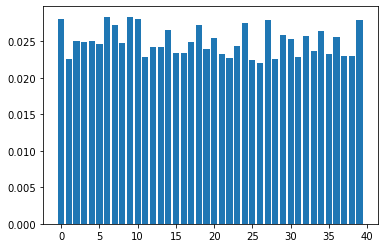

In [12]:
plt.bar([i for i in range(test_first_hitting_time.size(1))], test_first_hitting_time.squeeze().cpu().detach().numpy())

(0.0, 1.0)

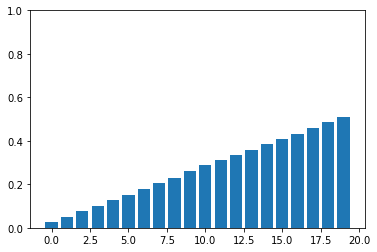

In [13]:
plt.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[:MAX_LENGTH], dim=0).cpu().detach().numpy())
plt.ylim([0,1])

(0.0, 1.0)

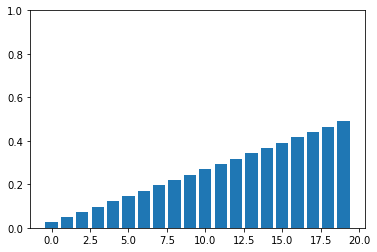

In [14]:
plt.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[MAX_LENGTH:], dim=0).cpu().detach().numpy())
plt.ylim([0,1])

# 4. Validating The Model

In [15]:
from poc_data import PocDataset

val_poc_raw_dataset = PocDataset(num_cases=2**5)
val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=1)
val_batch, val_event, val_time_to_event, val_latent_variable = next(iter(val_data_loader))
val_batch = val_batch.to(DEVICE)

encoder.eval()
decoder.eval()
#regress.eval()
causess.eval()

CauseSpecificSubnetwork(
  (layer1): Linear(in_features=131, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=40, bias=True)
)

In [16]:
loss1 = 0
loss2 = 0
loss3 = 0
epoch_loss = 0

for i, data in enumerate(val_data_loader):

    batch, event, time_to_event, _latent_variable = data

    batch = batch.to(DEVICE)
    event = event.to(DEVICE)
    time_to_event = time_to_event.to(DEVICE)
    _latent_variable = _latent_variable.to(DEVICE)

    encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
    encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
    encoder_hidden = encoder.initHidden(device=DEVICE)

    for ei in range(batch.size(1)):
        encoder_input = batch[0][ei].view(1,1,-1)
        encoder_output, encoder_hidden = encoder(encoder_input, encoder_hidden)
        encoder_hidden_vector[ei] = encoder_hidden[0,0]
        encoder_output_vector[ei] = encoder_output

    last_measurement = batch[0][ei]
    context_vector = decoder(last_measurement, encoder_hidden_vector)
    #estimated_latent_variable = regress(context_vector)
    first_hitting_time = causess(context_vector, last_measurement)

    loss1 += loss_1(first_hitting_time, event, time_to_event, MAX_LENGTH)
    loss3 += mse_loss(encoder_output_vector[:-1], batch.detach().squeeze(0)[1:])
    #loss4 += mse_loss(estimated_latent_variable, _latent_variable)

print("loss1=", loss1.item()/len(val_data_loader))
print("loss2=", loss2/len(val_data_loader))
print("loss3=", loss3.item()/len(val_data_loader))

loss1= 3.6521964073181152
loss2= 0.0
loss3= 72.98698425292969


loss1 record = 3.6
loss3 record = 13.9